In [8]:
import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt
from segment_anything import sam_model_registry, SamPredictor

In [4]:
# Load model
sam = sam_model_registry["vit_h"](checkpoint="../models/sam/sam_vit_h_4b8939.pth")
sam.to("cpu")

/Users/ayushjam/Desktop/ECE 285 VL/ECE285-Diffusion-Models-main/external/segment-anything/segment_anything/build_sam.py:105: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  st

Sam(
  (image_encoder): ImageEncoderViT(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 1280, kernel_size=(16, 16), stride=(16, 16))
    )
    (blocks): ModuleList(
      (0-31): 32 x Block(
        (norm1): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=1280, out_features=3840, bias=True)
          (proj): Linear(in_features=1280, out_features=1280, bias=True)
        )
        (norm2): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (lin1): Linear(in_features=1280, out_features=5120, bias=True)
          (lin2): Linear(in_features=5120, out_features=1280, bias=True)
          (act): GELU(approximate='none')
        )
      )
    )
    (neck): Sequential(
      (0): Conv2d(1280, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): LayerNorm2d()
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (3): LayerNorm2d

In [5]:
predictor = SamPredictor(sam)

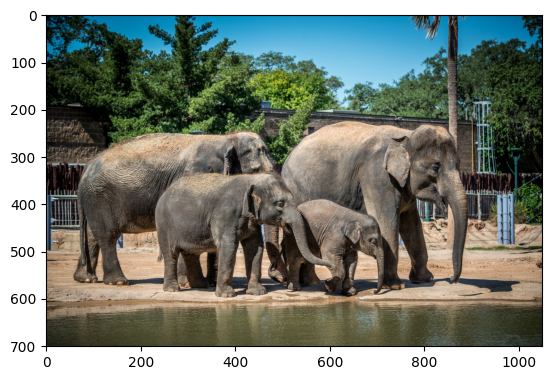

In [9]:
# Load image
image = cv2.imread("../data/elephant.jpg")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)

In [10]:
predictor.set_image(image)

In [17]:
# Example: box prompt
input_box = np.array([0, 0, image.shape[1], image.shape[0]])
masks, scores, logits = predictor.predict(box=input_box)


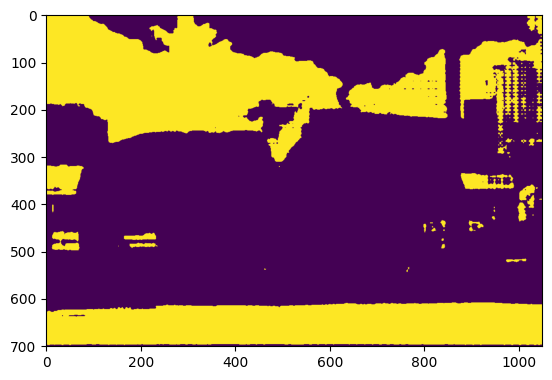

In [25]:
plt.imshow(masks[2].astype(np.uint8) * 255)

In [26]:
from segment_anything import SamAutomaticMaskGenerator

In [27]:
# Create mask generator
mask_generator = SamAutomaticMaskGenerator(sam)

masks = mask_generator.generate(image)

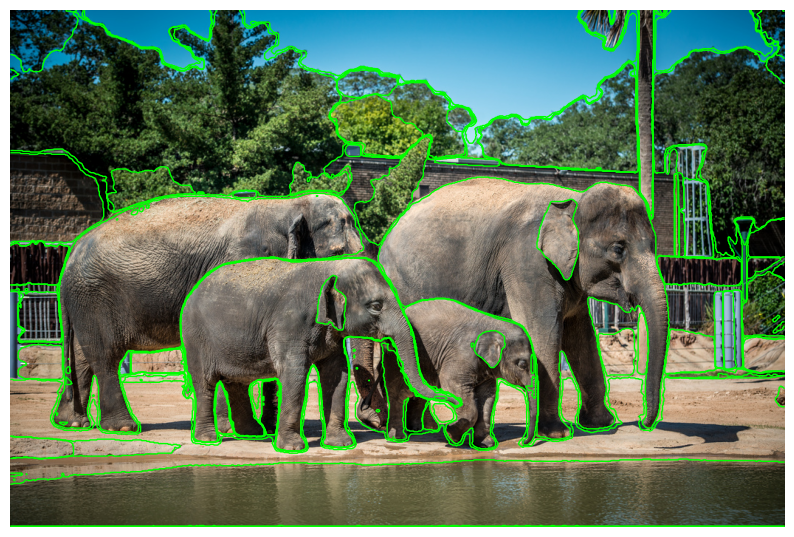

In [32]:
def show_masks_on_image(image, masks):
    plt.figure(figsize=(10, 10))
    plt.imshow(image)
    
    for mask in masks:
        seg = mask["segmentation"]
        plt.contour(seg, colors='lime', linewidths=1)
    
    plt.axis('off')
    plt.show()

show_masks_on_image(image, masks)

In [33]:
def get_mask_containing_point(masks, x, y):
    """
    Given a list of masks and a point (x, y), return the mask that contains the point.
    
    Args:
        masks (list of dict): Output from SAM's automatic mask generator.
        x (int): x-coordinate (column) of the point.
        y (int): y-coordinate (row) of the point.
        
    Returns:
        dict: The mask dictionary that contains the point, or None if not found.
    """
    for mask in masks:
        if mask['segmentation'][y, x]:  # Remember: row (y), then col (x)
            return mask
    return None

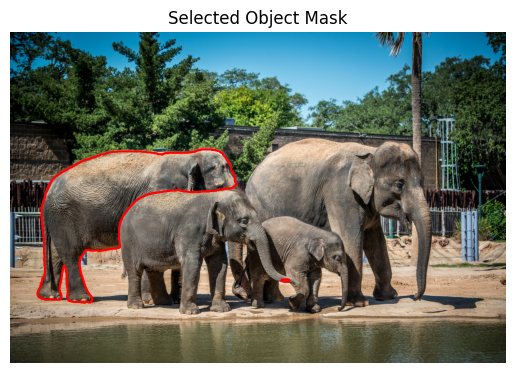

In [39]:
# Assume you have the image and masks already loaded
x, y = 350, 300  # Example: you want the object at (300, 250)

selected_mask = get_mask_containing_point(masks, x, y)

if selected_mask is not None:
    seg = selected_mask["segmentation"]
    plt.imshow(image)
    plt.contour(seg, colors='red')
    plt.title("Selected Object Mask")
    plt.axis('off')
    plt.show()
else:
    print("No mask found containing the point.")

In [40]:
len(masks)

69

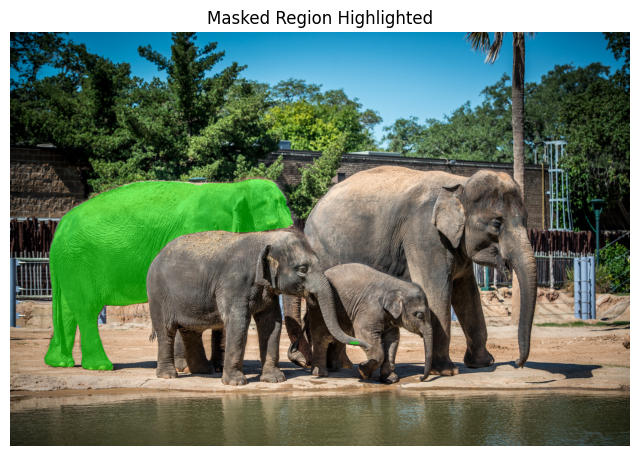

In [41]:
def show_mask_overlay(image, mask, color=(0, 255, 0), alpha=0.5):
    """
    Overlay a binary mask on an image with a given color and transparency.

    Args:
        image (np.ndarray): Original image (H, W, 3) in RGB.
        mask (np.ndarray): Binary mask (H, W) with True/1 where mask is present.
        color (tuple): RGB color to use for overlay.
        alpha (float): Transparency of overlay, between 0 (transparent) and 1 (solid).
    """
    overlay = image.copy()
    color = np.array(color).reshape(1, 1, 3)
    
    # Create a colored mask
    overlay[mask] = (1 - alpha) * overlay[mask] + alpha * color

    # Display the result
    plt.figure(figsize=(8, 8))
    plt.imshow(overlay.astype(np.uint8))
    plt.axis('off')
    plt.title("Masked Region Highlighted")
    plt.show()

seg = selected_mask["segmentation"]
show_mask_overlay(image, seg, color=(0, 255, 0), alpha=0.5)  # green mask


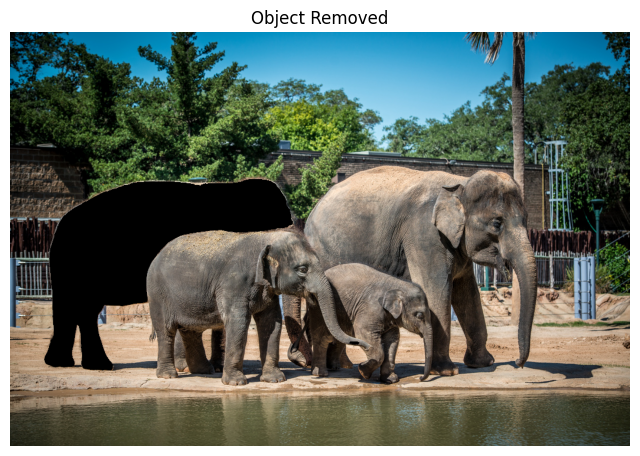

In [47]:
def remove_object(image, mask):
    overlay = image.copy()
    
    # Create a colored mask
    overlay[mask] = 0

    # Display the result
    plt.figure(figsize=(8, 8))
    plt.imshow(overlay.astype(np.uint8))
    plt.axis('off')
    plt.title("Object Removed")
    plt.show()

    image_seg = cv2.cvtColor(overlay, cv2.COLOR_RGB2BGR)
    cv2.imwrite("../data/elephant_seg.jpg", image_seg)

seg = selected_mask["segmentation"]
remove_object(image, seg)

In [66]:
from matplotlib.patches import Rectangle
from ipywidgets import interact
%matplotlib widget

@interact(mask_idx=(0, len(masks) - 1))
def display_mask(mask_idx=0):
    img_copy = image.copy()
    
    # Apply mask in red overlay
    mask = masks[mask_idx]
    overlay = img_copy.copy()
    overlay[mask > 0] = [255, 0, 0]  # red overlay
    blended = cv2.addWeighted(img_copy, 0.7, overlay, 0.3, 0)

    plt.figure(figsize=(8, 8))
    plt.imshow(blended)
    plt.axis('off')
    plt.title(f"Mask {mask_idx}")
    plt.show()

RuntimeError: 'widget is not a recognised GUI loop or backend name

In [59]:
selected_mask = None

def on_click(event):
    global selected_mask
    x, y = int(event.xdata), int(event.ydata)
    for i, mask in enumerate(masks):
        if mask[y, x]:
            selected_mask = i
            break
    display_mask(mask_idx=selected_mask)

fig, ax = plt.subplots()
ax.imshow(image)
fig.canvas.mpl_connect('button_press_event', on_click)
plt.title("Click on object to select")
plt.axis('off')
plt.show()


<IPython.core.display.Javascript object>